# TensorRT
https://developer.nvidia.com/tensorrt-getting-started

In [12]:
import tensorrt

In [13]:
print(tensorrt.__version__)

8.6.0


In [14]:
assert tensorrt.Builder(tensorrt.Logger())

[04/23/2023-20:41:33] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading


In [15]:
!dpkg-query -W tensorrt

dpkg-query: no packages found matching tensorrt


In [6]:
!wget https://s3.amazonaws.com/download.onnx/models/opset_8/resnet50.tar.gz

--2023-04-22 21:46:03--  https://s3.amazonaws.com/download.onnx/models/opset_8/resnet50.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.126.176, 52.216.92.205, 52.217.42.102, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.126.176|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-04-22 21:46:03 ERROR 403: Forbidden.



In [7]:
!tar xzf resnet50.tar.gz

tar (child): resnet50.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [16]:
BATCH_SIZE=64

In [17]:
import numpy as np
PRECISION = np.float32

In [18]:
!trtexec --onnx=resnet50d.onnx --saveEngine=resnet_engine.trt

/bin/bash: line 1: trtexec: command not found


In [1]:
import torchvision.models as models
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)

/home/lkk/miniconda3/envs/mypy310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lkk/miniconda3/envs/mypy310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import torch

BATCH_SIZE = 64
dummy_input=torch.randn(BATCH_SIZE, 3, 224, 224)

In [3]:
import torch.onnx
torch.onnx.export(resnext50_32x4d, dummy_input, "resnext50_onnx_model.onnx", verbose=False)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [4]:
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np

url='https://images.dog.ceo/breeds/retriever-golden/n02099601_3004.jpg'
img = resize(io.imread(url), (224, 224))
img = np.expand_dims(np.array(img, dtype=np.float32), axis=0) # Expand image to have a batch dimension
input_batch = np.array(np.repeat(img, BATCH_SIZE, axis=0), dtype=np.float32) # Repeat across the batch dimension

input_batch.shape

(64, 224, 224, 3)

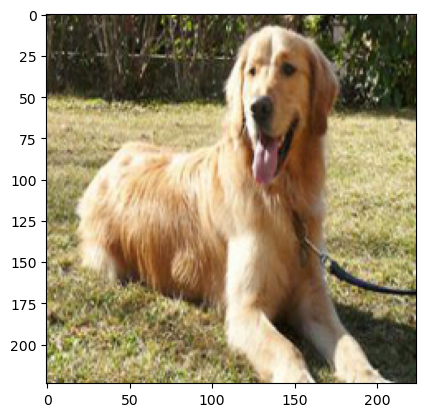

In [5]:
plt.imshow(input_batch[0].astype(np.float32))

In [6]:
resnet50_gpu = resnext50_32x4d.to("cuda").eval()
input_batch_chw = torch.from_numpy(input_batch).transpose(1,3).transpose(2,3)
input_batch_gpu = input_batch_chw.to("cuda")

input_batch_gpu.shape

torch.Size([64, 3, 224, 224])

In [7]:
with torch.no_grad():
    predictions = np.array(resnet50_gpu(input_batch_gpu).cpu())

predictions.shape

(64, 1000)

In [8]:
%%timeit

with torch.no_grad():
    preds = np.array(resnet50_gpu(input_batch_gpu).cpu())

73.6 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 time FP16 precision performance:

In [9]:
resnet50_gpu_half = resnet50_gpu.half()
input_half = input_batch_gpu.half()

with torch.no_grad():
    preds = np.array(resnet50_gpu_half(input_half).cpu()) # Warm Up
    
preds.shape

(64, 1000)

In [10]:
%%timeit

with torch.no_grad():
    preds = np.array(resnet50_gpu_half(input_half).cpu())

32.6 ms ± 838 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
indices = (-predictions[0]).argsort()[:5]
print("Class | Likelihood")
list(zip(indices, predictions[0][indices]))

Class | Likelihood


[(207, 11.581506),
 (160, 10.3288555),
 (226, 9.72894),
 (257, 9.646758),
 (222, 8.116018)]

The image we are using is of a Golden Retriever, which is class 207 in the ImageNet dataset our model was trained on.

## Using Lower precision

In [3]:
import torch
import numpy as np
BATCH_SIZE = 32
USE_FP16 = True
target_dtype = np.float16 if USE_FP16 else np.float32

In [4]:
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np

url='https://images.dog.ceo/breeds/retriever-golden/n02099601_3004.jpg'
img = resize(io.imread(url), (224, 224))
input_batch = np.array(np.repeat(np.expand_dims(np.array(img, dtype=np.float32), axis=0), BATCH_SIZE, axis=0), dtype=np.float32)

input_batch.shape

(32, 224, 224, 3)

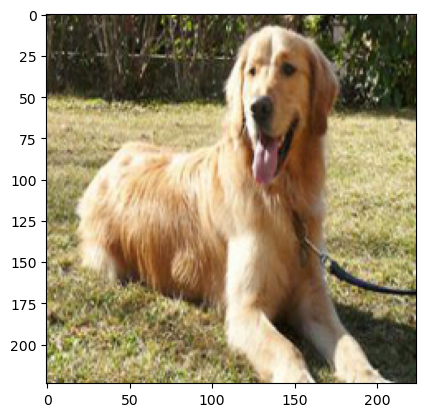

In [5]:
plt.imshow(input_batch[0].astype(np.float32))

In [6]:
import torch
from torchvision.transforms import Normalize

def preprocess_image(img):
    norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    result  = norm(torch.from_numpy(img).transpose(0,2).transpose(1,2))
    return np.array(result, dtype=np.float16)

preprocessed_images = np.array([preprocess_image(image) for image in input_batch])

In [7]:
import tensorrt

In [2]:
!trtexec --version

&&&& RUNNING TensorRT.trtexec [TensorRT v8600] # trtexec --version
[04/24/2023-21:43:38] [E] Model missing or format not recognized
=== Model Options ===
  --uff=<file>                UFF model
  --onnx=<file>               ONNX model
  --model=<file>              Caffe model (default = no model, random weights used)
  --deploy=<file>             Caffe prototxt file
  --output=<name>[,<name>]*   Output names (it can be specified multiple times); at least one output is required for UFF and Caffe
  --uffInput=<name>,X,Y,Z     Input blob name and its dimensions (X,Y,Z=C,H,W), it can be specified multiple times; at least one is required for UFF models
  --uffNHWC                   Set if inputs are in the NHWC layout instead of NCHW (use X,Y,Z=H,W,C order in --uffInput)

=== Build Options ===
  --maxBatch                         Set max batch size and build an implicit batch engine (default = same size as --batch)
                                     This option should not be used when the

Tell trtexec to expect a fixed batch size when optimizing (the exact value of this batch size will be inferred from the ONNX file)

--explicitBatch

In [8]:
if USE_FP16:
    !~/Developer/TensorRT-8.6.0.12/bin/trtexec --onnx=resnext50_onnx_model.onnx --saveEngine=resnet_engine_pytorch.trt  --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16
else:
    !~/Developer/TensorRT-8.6.0.12/bin/trtexec --onnx=resnext50_onnx_model.onnx --saveEngine=resnet_engine_pytorch.trt  --explicitBatch

&&&& RUNNING TensorRT.trtexec [TensorRT v8600] # /home/lkk/Developer/TensorRT-8.6.0.12/bin/trtexec --onnx=resnext50_onnx_model.onnx --saveEngine=resnet_engine_pytorch.trt --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16
[04/24/2023-21:44:12] [W] --explicitBatch flag has been deprecated and has no effect!
[04/24/2023-21:44:12] [W] Explicit batch dim is automatically enabled if input model is ONNX or if dynamic shapes are provided when the engine is built.
[04/24/2023-21:44:12] [I] === Model Options ===
[04/24/2023-21:44:12] [I] Format: ONNX
[04/24/2023-21:44:12] [I] Model: resnext50_onnx_model.onnx
[04/24/2023-21:44:12] [I] Output:
[04/24/2023-21:44:12] [I] === Build Options ===
[04/24/2023-21:44:12] [I] Max batch: explicit batch
[04/24/2023-21:44:12] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default
[04/24/2023-21:44:12] [I] minTiming: 1
[04/24/2023-21:44:12] [I] avgTiming: 8
[04/24/2023-21:44:12] [I] Precis

In [9]:
! ls resnet_engine_pytorch*

resnet_engine_pytorch.trt


load it into the native Python TensorRT runtime. Need to install pycuda via pip

In [10]:
%%time

import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

f = open("resnet_engine_pytorch.trt", "rb")
runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING)) 

engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()

CPU times: user 583 ms, sys: 180 ms, total: 763 ms[04/24/2023-21:47:15] [TRT] [W] 
Wall time: 1.12 s
CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading


In [11]:
import numpy as np

# need to set input and output precisions to FP16 to fully enable it
output = np.empty([BATCH_SIZE, 1000], dtype = target_dtype) 

# allocate device memory
d_input = cuda.mem_alloc(1 * input_batch.nbytes)
d_output = cuda.mem_alloc(1 * output.nbytes)

bindings = [int(d_input), int(d_output)]

stream = cuda.Stream()

prediction function involves a copy from CPU RAM to GPU VRAM, executing the model, then copying the results back from GPU VRAM to CPU RAM:

In [12]:
def predict(batch): # result gets copied into output
    # transfer input data to device
    cuda.memcpy_htod_async(d_input, batch, stream)
    # execute model
    context.execute_async_v2(bindings, stream.handle, None)
    # transfer predictions back
    cuda.memcpy_dtoh_async(output, d_output, stream)
    # syncronize threads
    stream.synchronize()
    
    return output

In [13]:
print("Warming up...")

pred = predict(preprocessed_images)

print("Done warming up!")

Warming up...
Done warming up!


In [14]:
%%timeit

pred = predict(preprocessed_images)

18.8 ms ± 8.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
indices = (-pred[0]).argsort()[:5]
print("Class | Probability (out of 1)")
list(zip(indices, pred[0][indices]))

Class | Probability (out of 1)


[(207, 14.18), (256, 8.05), (208, 7.715), (226, 7.68), (257, 7.625)]

207 is the ground truth correct class (Golden Retriever)

ref: https://github.com/NVIDIA/TensorRT/blob/main/quickstart/IntroNotebooks/4.%20Using%20PyTorch%20through%20ONNX.ipynb